In [178]:
#load libraries
import numpy as np
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm, lognorm
import seaborn as sns
sns.set()
sns.set_style('white')
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import random - have function named random...
import sys
from itertools import combinations 
import time
from scipy import stats
from sklearn.svm import SVC
from mpl_toolkits import mplot3d
from shapely import geometry
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

In [2]:
#load data
raw_data = np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8,9))
raw_data_copy=np.copy(raw_data)
edge_grains=np.unique(raw_data[np.where(raw_data[:,6]==1),5])

In [3]:
def js_divergence_scipy(hist1,hist2):
    return (distance.jensenshannon(hist1, hist2, base=2))**2

def nearest_neighbors(values, all_values, nbr_neighbors=1):
    nn = NearestNeighbors(nbr_neighbors, metric='euclidean', algorithm='kd_tree').fit(all_values)
    dists, idxs = nn.kneighbors(values)
    return idxs

def hexagonal_sym_ops():
    #everything to calculate disorientations
    a=sqrt(0.75)

    #12 hexagonal close-packed crystal symmetry operators
    op25=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
    op26=np.array([[-0.5, a, 0],[-a, -0.5, 0],[0, 0, 1]])
    op27=np.array([[-0.5, -a, 0],[a, -0.5, 0],[0, 0, 1]])
    op28=np.array([[0.5, a, 0],[-a, 0.5, 0],[0, 0, 1]])
    op2=np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]])
    op30=np.array([[0.5, -a, 0],[a, 0.5, 0],[0, 0, 1]])
    op31=np.array([[-0.5, -a, 0],[-a, 0.5, 0],[0, 0, -1]])
    op32=np.array([[1, 0, 0],[0, -1, 0],[0, 0, -1]])
    op33=np.array([[-0.5, a, 0],[a, 0.5, 0],[0, 0, -1]])
    op34=np.array([[0.5, a, 0],[a, -0.5, 0],[0, 0, -1]])
    op35=np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]])
    op36=np.array([[0.5, -a, 0],[-a, -0.5, 0],[0, 0, -1]])

    op25,op26,op27,op28,op2,op30,op31,op32,op33,op34,op35,op36

    #list of hexagonal sym ops
    return [op25,op26,op27,op28,op2,op30,op31,op32,op33,op34,op35,op36]

#input is an array in radians as follows euler=[angle_one,angle_two,angle_three]
def misorientation(euler_one, euler_two,sym_op):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
#     #misorientation matrix
    delta_g=np.matmul(g_one,np.linalg.inv(g_two))
    
    #disorientation matrix
    delta_gd=np.matmul(sym_op,delta_g)
    
    #misorientation angle
    try:
        theta=np.arccos((np.trace(delta_gd)-1)/2)
    #error handling for rounding errors outside of domain
    except:
        if (((np.trace(delta_gd)-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)


#find the minimum misorientation using sym ops
def disorientation(euler_one, euler_two):
    global hex_sym_ops
    
    misorientation_list=[]
    for sym_op in hex_sym_ops:
        misorientation_list.append(misorientation(euler_one, euler_two,sym_op))
    
    #disorientation is the minimum of the 24 misorientations - for cubic symmetry 
    return min(misorientation_list)

In [4]:
hex_sym_ops=hexagonal_sym_ops()

In [14]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
#                levels=[-1, 0, 1], alpha=0.5,
#                linestyles=['--', '-', '--'])
               levels=[0], alpha=0.5,
               linestyles=['-'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def svc_decision_boundary_2(model,x_lim=(0,10),y_lim=(0,10),numb=300):
    """Return the decision boundary coordinates for a 2D SVC"""

#     x_lim=(2,8)
#     y_lim=(0,4)
    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    boundary_coords = v[:,[0,1]]
    
    return boundary_coords

def svc_decision_boundary_length(model,x_lim=(0,10),y_lim=(0,10),numb=30):
    """Return the decision boundary coordinates for a 2D SVC"""

#     x_lim=(2,8)
#     y_lim=(0,4)
    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    boundary_coords = v[:,[0,1]]
    
    x = np.ravel(boundary_coords[:,0])
    y = np.ravel(boundary_coords[:,1])

    dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2

    return np.sum(np.sqrt(dist_array))

def boundary_search(slice_1, slice_2, svm_model, num_iter=4):
    slice_2=slice_2[0][0]
    coord_1=slice_1[0:2]
    coord_2=slice_2[0:2]
    ID_1=slice_1[2]
    ID_2=slice_2[2]
    while num_iter > 0:
        midpt = (coord_1+coord_2)/2
        new_ID=svm_model.predict(midpt.reshape(1, -1))
        
        if new_ID == ID_1:
            coord_1=midpt
        else: # new_ID==ID_2
            coord_2=midpt
            
        num_iter-=1
        
    return midpt

def point_adj_dict(data):
    coords=data[:,[0,1]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh

def grain_adj_dict(data, point_adj):
    grain_adj=defaultdict(set)
    for key in point_adj:
        grain_ID_1=data[key][2]
        for value in point_adj[key]:
            grain_ID_2=data[value][2]
            if grain_ID_1 != grain_ID_2:
                #array boundary
                data[key,3]=1
                data[value,3]=1
                grain_ID_1=int(grain_ID_1)
                grain_ID_2=int(grain_ID_2)
                #array grain
                data[key,4]=grain_ID_2
                data[value,4]=grain_ID_1
                #dict grain
                grain_adj[int(grain_ID_1)].add(grain_ID_2)
                grain_adj[int(grain_ID_2)].add(grain_ID_1)
    return grain_adj

In [15]:
def grain_misorients(array, hist_bool=True, return_p=False, num_samples=200):
    global p

    #initialize misorientations and lengths/weights for histogram
    avg_boundary_disorients = np.zeros((100000,1))
    boundary_lens = np.zeros((100000,1))
    
    #create boundaries
    X=array[:,3:5]
    Y=array[:,5]
    
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    model = SVC(kernel='rbf', C=1e10, gamma=10e-3)
    model.fit(X, Y)
    
    # create grid to evaluate model
    x = np.linspace(x_min, x_max, num_samples)
    y = np.linspace(y_min, y_max, num_samples)
    xx, yy = np.meshgrid(x, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    svm_coords=np.stack((xx.ravel(),yy.ravel(),Z), axis=-1)

    #array to hold boundaries and adj grain
    bounds_grains=np.zeros((len(svm_coords),2))
    svm=np.concatenate((svm_coords,bounds_grains),axis=1)
    
    #create ajd dict
    point_adj=point_adj_dict(svm)
    # create grain adj dict
    grain_adj=grain_adj_dict(svm, point_adj)

    #**************************************
    
    #index for len/misorient results
    index=0
    # for each grain
    for grain_ID_1 in grain_adj:
#     for grain_ID_1 in [1]:
        #slice grain 1 and add row IDs
        grain_slice_1=array[np.where(array[:,5]==grain_ID_1)]
        grain_slice_1=np.concatenate((grain_slice_1,np.arange(0,len(grain_slice_1)).reshape(-1,1)),axis=1)
        #for each neighboring grain
        for grain_ID_2 in grain_adj[grain_ID_1]:
            #get coords of grain boundaries (1 & 2)
            logic_1=(svm[:,2]==grain_ID_1) & (svm[:,3]==1) & (svm[:,4]==grain_ID_2)
            logic_2=(svm[:,2]==grain_ID_2) & (svm[:,3]==1) & (svm[:,4]==grain_ID_1)
            svm_slice=svm[np.where(logic_1)]
            svm_slice_2=svm[np.where(logic_2)]
            #likely caused by the fact that although the dict can have multiple neighbors, column 4 can only hold one
            if len(svm_slice_2) <1:
                break
            #binary search to smooth steps
            midpts=np.zeros((1,2))
            for row_1 in svm_slice:
                row_2=svm_slice_2[nearest_neighbors(row_1[0:2].reshape(1, -1), svm_slice_2[:,0:2], nbr_neighbors=1)]
                midpt=boundary_search(row_1,row_2,model)
                midpts=np.vstack((midpts,midpt))
            midpts=np.delete(midpts,0,0)
            
#             plt.scatter(svm_slice[:,0],svm_slice[:,1],c='blue')
#             plt.scatter(svm_slice_2[:,0],svm_slice_2[:,1],c='orange')
#             plt.scatter(midpts[:,0],midpts[:,1],c='green')
#             return 'yeet'
            
            #append length
            x=midpts[:,0]
            y=midpts[:,1]
            dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2
            boundary_lens[index] = np.sum(np.sqrt(dist_array))
            
            #slice grain 2
            grain_slice_2=array[np.where(array[:,5]==grain_ID_2)]
            grain_slice_2=np.concatenate((grain_slice_2,np.arange(0,len(grain_slice_2)).reshape(-1,1)),axis=1)
            
            #create two new columns to hold nearest neighbor and a third column for misorientation
            svm_coords=svm_slice[:,[0,1]]
            neighbors_misorients=np.zeros((len(svm_coords),3))
            coords_misorient=np.concatenate((svm_coords,neighbors_misorients),axis=1)

            #row ID of nearest coord in grain 1
            row_1_ID=0
            #for each SVM boundary point
            for row_1 in coords_misorient:
                coords_1=row_1[0:2]
                distances_and_row_IDs=defaultdict(set)
                #for each point in the first grain
                for row_2 in grain_slice_1:
                    coords_2=row_2[3:5]
                    #calculate distance
                    dist=round(distance.euclidean(coords_1,coords_2),3)
                    #add row ID of grain boundary point for misorient
                    distances_and_row_IDs[dist].add(row_2[6])
                #find minimum distance
                min_dist = min(list(distances_and_row_IDs.keys()))
                #add row ID of min dist
                bound_1_ID=list(distances_and_row_IDs[min_dist])
                coords_misorient[row_1_ID,2]=bound_1_ID[0]
                row_1_ID+=1       

            #row ID of nearest coord in grain 2
            row_1_ID=0
            #for each SVM boundary point
            for row_1 in coords_misorient:
                coords_1=row_1[0:2]
                distances_and_row_IDs=defaultdict(set)
                #for each point in the first grain boundary
                for row_2 in grain_slice_2:
                    coords_2=row_2[3:5]
                    #calculate distance
                    dist=round(distance.euclidean(coords_1,coords_2),3)
                    #add row ID of grain boundary point for misorient
                    distances_and_row_IDs[dist].add(row_2[6])
                #find minimum distance
                min_dist = min(list(distances_and_row_IDs.keys()))
                #add row ID of min dist
                bound_1_ID=list(distances_and_row_IDs[min_dist])
                coords_misorient[row_1_ID,3]=bound_1_ID[0]
                row_1_ID+=1 

            #calculate each misorientation
            row_ID=0
            for row in coords_misorient:
                key=int(coords_misorient[row_ID,2])
                euler_one=[grain_slice_1[key][0],grain_slice_1[key][1],grain_slice_1[key][2]]
                value=int(coords_misorient[row_ID,3])
                euler_two=[grain_slice_2[value][0],grain_slice_2[value][1],grain_slice_2[value][2]]
                coords_misorient[row_ID,4]=disorientation(euler_one,euler_two)
                row_ID+=1

            #find the total average and append
            avg_boundary_disorients[index]=np.mean(coords_misorient[:,4])
            
            #increment index!
            index+=1
                
    #**************************************
    
    #discard misorientations below 15 degrees
    keep=np.where(avg_boundary_disorients>15)
    abd = avg_boundary_disorients[keep]
    bl = boundary_lens[keep]
    
    #arbitrarily scale up so they become ints (will be scaled back by norming)
    scaled_bl=bl*1000
    scaled_bl=scaled_bl.astype(int)
    #disorients weighted by boundary length
    count=[]
    for x in np.arange(0,len(abd)):
        weighted_abd=[abd[x].astype(list)]*int(scaled_bl[x])
        count.extend(weighted_abd)

    if return_p==True:
        plt.hist(count, bins=np.arange(15,100,2), range=(15,100), density=True)
        q, q_bin_edges = np.histogram(count, bins=np.arange(15,100,2), range=(15,100), density=True)
        q = np.append(q, 0)
        return q
    
    #create histogram
    elif hist_bool==True:
        q, q_bin_edges = np.histogram(count, bins=np.arange(15,100,2), range=(15,100), density=True)
        q = np.append(q, 0)
#         return js_divergence_scipy(p,q)
        plt.hist(count, bins=np.arange(15,100,2), range=(15,100), density=True)
        return np.sum(bl)/2
    
    else:
        sample_mean=np.mean(count)
        sample_var=np.var(count)
        return sample_mean, sample_var  

294.9864403663328


C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

5271.924351078408
Stored 'x' (float64)


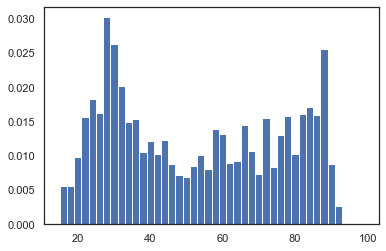

In [16]:
#grain misorients with same res as raw data
print(sqrt(len(raw_data)))

x=grain_misorients(raw_data, num_samples=295)
print(x)
%store x

In [10]:
# y=grain_misorients(raw_data_slice)
# print(y)
# %store y

In [394]:
def full_image_boundary_length_sum(array,num_samples=200):
    svm_coords=array[:,3:6]
    
    #initialize misorientations and lengths/weights for histogram
    avg_boundary_disorients = np.zeros((100000,1))
    boundary_lens = np.zeros((100000,1))
    
    #array to hold boundaries and adj grain
    bounds_grains=np.zeros((len(svm_coords),2))
    svm=np.concatenate((svm_coords,bounds_grains),axis=1)
    
    #create ajd dict
    point_adj=point_adj_dict(svm)
    # create grain adj dict
    grain_adj=grain_adj_dict(svm, point_adj)
    
    #**************************************
    
    #index for len/misorient results
    index=0
    # for each grain
    for grain_ID_1 in grain_adj:
#     for grain_ID_1 in [1]:
        #slice grain 1 and add row IDs
        grain_slice_1=array[np.where(array[:,5]==grain_ID_1)]
        grain_slice_1=np.concatenate((grain_slice_1,np.arange(0,len(grain_slice_1)).reshape(-1,1)),axis=1)
        #for each neighboring grain
        for grain_ID_2 in grain_adj[grain_ID_1]:
            #get coords of grain boundaries (1 & 2)
            logic_1=(svm[:,2]==grain_ID_1) & (svm[:,3]==1) & (svm[:,4]==grain_ID_2)
            logic_2=(svm[:,2]==grain_ID_2) & (svm[:,3]==1) & (svm[:,4]==grain_ID_1)
            svm_slice=svm[np.where(logic_1)]
            svm_slice_2=svm[np.where(logic_2)]
            #likely caused by the fact that although the dict can have multiple neighbors, column 4 can only hold one
            if len(svm_slice_2) <1:
                break
            #binary search to smooth steps - only one iteration for smoothing in raw data
            midpts=np.zeros((1,2))
            for row_1 in svm_slice:
#                 print(row_1[0:2].reshape(1, -1))
#                 print(svm_slice_2[:,0:2])
                row_2=svm_slice_2[nearest_neighbors(row_1[0:2].reshape(1, -1), svm_slice_2[:,0:2], nbr_neighbors=1)]
                row_2=row_2[0][0]
                coord_1=row_1[0:2]
                coord_2=row_2[0:2] 
                midpt = (coord_1+coord_2)/2
                midpts=np.vstack((midpts,midpt))
            midpts=np.delete(midpts,0,0)
            
#             plt.scatter(svm_slice[:,0],svm_slice[:,1],c='blue')
#             plt.scatter(svm_slice_2[:,0],svm_slice_2[:,1],c='orange')
#             plt.scatter(midpts[:,0],midpts[:,1],c='green')
#             return 'yeet'
            
            #append length
            x=midpts[:,0]
            y=midpts[:,1]
            dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2
            boundary_lens[index] = np.sum(np.sqrt(dist_array))
#             print(np.sum(np.sqrt(dist_array)))
            #slice grain 2
            grain_slice_2=array[np.where(array[:,5]==grain_ID_2)]
            grain_slice_2=np.concatenate((grain_slice_2,np.arange(0,len(grain_slice_2)).reshape(-1,1)),axis=1)
            
            #create two new columns to hold nearest neighbor and a third column for misorientation
            svm_coords=svm_slice[:,[0,1]]
            neighbors_misorients=np.zeros((len(svm_coords),3))
            coords_misorient=np.concatenate((svm_coords,neighbors_misorients),axis=1)

            #row ID of nearest coord in grain 1
            row_1_ID=0
            #for each SVM boundary point
            for row_1 in coords_misorient:
                coords_1=row_1[0:2]
                distances_and_row_IDs=defaultdict(set)
                #for each point in the first grain
                for row_2 in grain_slice_1:
                    coords_2=row_2[3:5]
                    #calculate distance
                    dist=round(distance.euclidean(coords_1,coords_2),3)
                    #add row ID of grain boundary point for misorient
                    distances_and_row_IDs[dist].add(row_2[6])
                #find minimum distance
                min_dist = min(list(distances_and_row_IDs.keys()))
                #add row ID of min dist
                bound_1_ID=list(distances_and_row_IDs[min_dist])
                coords_misorient[row_1_ID,2]=bound_1_ID[0]
                row_1_ID+=1       

            #row ID of nearest coord in grain 2
            row_1_ID=0
            #for each SVM boundary point
            for row_1 in coords_misorient:
                coords_1=row_1[0:2]
                distances_and_row_IDs=defaultdict(set)
                #for each point in the first grain boundary
                for row_2 in grain_slice_2:
                    coords_2=row_2[3:5]
                    #calculate distance
                    dist=round(distance.euclidean(coords_1,coords_2),3)
                    #add row ID of grain boundary point for misorient
                    distances_and_row_IDs[dist].add(row_2[6])
                #find minimum distance
                min_dist = min(list(distances_and_row_IDs.keys()))
                #add row ID of min dist
                bound_1_ID=list(distances_and_row_IDs[min_dist])
                coords_misorient[row_1_ID,3]=bound_1_ID[0]
                row_1_ID+=1 

            #calculate each misorientation
            row_ID=0
            for row in coords_misorient:
                key=int(coords_misorient[row_ID,2])
                euler_one=[grain_slice_1[key][0],grain_slice_1[key][1],grain_slice_1[key][2]]
                value=int(coords_misorient[row_ID,3])
                euler_two=[grain_slice_2[value][0],grain_slice_2[value][1],grain_slice_2[value][2]]
                coords_misorient[row_ID,4]=disorientation(euler_one,euler_two)
                row_ID+=1

            #find the total average and append
            avg_boundary_disorients[index]=np.mean(coords_misorient[:,4])
#             print(np.mean(coords_misorient[:,4]))
            
            #increment index!
            index+=1
                
    #**************************************
    
    #discard misorientations below 15 degrees
    keep=np.where(avg_boundary_disorients>15)
    abd = avg_boundary_disorients[keep]
    bl = boundary_lens[keep]
    
    #arbitrarily scale up so they become ints (will be scaled back by norming)
    scaled_bl=bl*1000
    scaled_bl=scaled_bl.astype(int)
    #disorients weighted by boundary length
    count=[]
    for x in np.arange(0,len(abd)):
        weighted_abd=[abd[x].astype(list)]*int(scaled_bl[x])
        count.extend(weighted_abd)
    
    q, q_bin_edges = np.histogram(count, bins=np.arange(15,100,2), range=(15,100), density=True)
    q = np.append(q, 0)
    plt.hist(count, bins=np.arange(15,100,2), range=(15,100), density=True)
    return np.sum(bl)/2

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_s

5642.9473287370465
Stored 'y' (float64)


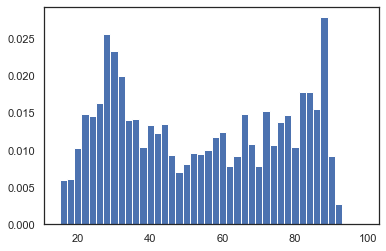

In [387]:
y=full_image_boundary_length_sum(raw_data)
print(y)
%store y

In [ ]:
#why all the errors?

In [9]:
# #TESTING
# array=raw_data_slice

# #create boundaries
# X=array[:,3:5]
# Y=array[:,5]

# x_min, x_max = X[:, 0].min(), X[:, 0].max()
# y_min, y_max = X[:, 1].min(), X[:, 1].max()

# model = SVC(kernel='rbf', C=1e10, gamma=1)
# model.fit(X, Y)
# num_samples=200
# # create grid to evaluate model
# x = np.linspace(x_min, x_max, num_samples)
# y = np.linspace(y_min, y_max, num_samples)
# xx, yy = np.meshgrid(x, y)
# Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
# svm_coords=np.stack((xx.ravel(),yy.ravel(),Z), axis=-1)

# #array to hold boundaries and adj grain
# bounds_grains=np.zeros((len(svm_coords),2))
# svm=np.concatenate((svm_coords,bounds_grains),axis=1)

# #create ajd dict
# point_adj=point_adj_dict(svm)
# # create grain adj dict
# grain_adj=grain_adj_dict(svm, point_adj)

# #**************************************

# # for each grain
# grain_ID_1=99

# #slice grain 1 and add row IDs
# grain_slice_1=array[np.where(array[:,5]==grain_ID_1)]
# grain_slice_1=np.concatenate((grain_slice_1,np.arange(0,len(grain_slice_1)).reshape(-1,1)),axis=1)

# #for each neighboring grain
# grain_ID_2=42
    
# #get coords of grain boundary (1 & 2)
# logic_1=(svm[:,2]==grain_ID_1) & (svm[:,3]==1) & (svm[:,4]==grain_ID_2)
# logic_2=(svm[:,2]==grain_ID_2) & (svm[:,3]==1) & (svm[:,4]==grain_ID_1)
# # svm_slice=svm[np.where((logic_one) | (logic_two))]
# svm_slice=svm[np.where(logic_1)]
# svm_slice_2=svm[np.where(logic_2)]

# midpts=np.zeros((1,2))
# for row_1 in svm_slice:
#     row_2=svm_slice_2[nearest_neighbors(row_1[0:2].reshape(1, -1), svm_slice_2[:,0:2], nbr_neighbors=1)]
#     midpt=boundary_search(row_1,row_2)
#     midpts=np.vstack((midpts,midpt))
# midpts=np.delete(midpts,0,0)


# x=midpts[:,0]
# y=midpts[:,1]
# dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2
# #append length
# print(np.sum(np.sqrt(dist_array)))
    
# plt.xlim(0,2.25)
# plt.ylim(5.8,6.9)
# sns.scatterplot(x=svm_slice[:,0],y=svm_slice[:,1],marker='o',label='Boundary One')
# sns.scatterplot(x=svm_slice_2[:,0],y=svm_slice_2[:,1],marker='o',label='Boundary Two')
# sns.scatterplot(x=midpts[:,0],y=midpts[:,1],marker='o',label='Binary Search')

In [274]:
def grain_areas_new(array, hist_bool=True, num_bins=25, num_samples=200):
    global p
    global edge_grains
    
    #array to hold the areas of each grain
    grain_IDs=np.unique(array[:,5])
    areas=np.zeros((len(grain_IDs),1))
    grain_IDs_and_areas=np.concatenate((grain_IDs.reshape(-1,1),areas.reshape(-1,1)),axis=1)
    
    #create boundaries
    X=array[:,3:5]
    Y=array[:,5]
    
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    model = SVC(kernel='rbf', C=1e10, gamma=1)
    model.fit(X, Y)
    
    # create grid to evaluate model
    x = np.linspace(x_min, x_max, num_samples)
    y = np.linspace(y_min, y_max, num_samples)
    xx, yy = np.meshgrid(x, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    svm_coords=np.stack((xx.ravel(),yy.ravel(),Z), axis=-1)
    
    #find area of each gridpoint
    total_area=(x_max-x_min)*(y_max-y_min)
    gridpt_area=total_area/(num_samples)**2

    #array to hold boundaries and adj grain
    bounds_grains=np.zeros((len(svm_coords),2))
    svm=np.concatenate((svm_coords,bounds_grains),axis=1)
    
    #create point ajd dict
    point_adj=point_adj_dict(svm)
    #create grain adj dict
    grain_adj=grain_adj_dict(svm, point_adj)
    
    #**************************************
    
    # for each grain
    for grain_ID_1 in grain_adj:
#         #get coords of grain boundary
#         svm_slice=svm[np.where((svm[:,2]==grain_ID_1) & (svm[:,3]==1)),0:2]
#         svm_slice=svm_slice[0]
# #         print(svm_slice[:,0])
# #         print(svm_slice[:,1])
# #         plt.scatter(svm_slice[:,0],svm_slice[:,1])
#         #create polygon
#         poly = geometry.Polygon(svm_slice)
#         if grain_ID_1==59:
#             plt.scatter(svm_slice[:,0],svm_slice[:,1],c='black')
#             plt.plot(*poly.exterior.xy)
#         #get area
#         poly_area=poly.area  
#         #append to array
#         grain_IDs_and_areas[(np.where(grain_IDs_and_areas[:,0]==grain_ID_1)),1]=poly_area
        
        #get all coords of grain
        svm_slice=svm[np.where(svm[:,2]==grain_ID_1),0:2]
        svm_slice=svm_slice[0]
        #get area
        poly_area=len(svm_slice)*gridpt_area
        #append to array
        grain_IDs_and_areas[(np.where(grain_IDs_and_areas[:,0]==grain_ID_1)),1]=poly_area
    print(np.sum(grain_IDs_and_areas[:,1]))        
    #double edge grains    
    row_ID=0
    for row in grain_IDs_and_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains):
            #double the total grain area
            grain_IDs_and_areas[row_ID,1]*=2
        row_ID+=1      
    
    count=grain_IDs_and_areas[:,1]
    
    #**************************************
    
    if hist_bool==True:
#         plt.hist(count, bins=num_bins, range=(0.01,50), density=True)
        q, q_bin_edges = np.histogram(count, bins=num_bins, range=(0.01,50), density=True)
        q = np.append(q, 0)
#         return js_divergence_scipy(p,q)
    
    else:
        count=count[np.where(count>0)]
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [275]:
xy_max=12
raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]
grain_areas_new(raw_data_slice)
#slight underestimation, but much better

141.3354


In [ ]:
#use area of each point as a approximation instead of drawing alpha shape concave hull

In [111]:
# def grain_areas_test(array,sample,strategy='random',budget=5,num_samples=200,num_bins=25,return_p=False):   
#     global p
#     global edge_grains
    
#     #slice data
#     indexes=np.random.choice(array.shape[0], sample, replace=False)
#     random_raw_data=array[indexes, :]
#     unlabeled_raw_data=np.delete(array,indexes,axis=0)
#     coords=unlabeled_raw_data[:,3:5]

#     #create boundaries
#     X=random_raw_data[:,3:5]
#     Y=random_raw_data[:,5]
#     #needs more than one grain and four points
#     if (len(np.unique(Y)) < 2) or (len(X) < 4):
#         return np.nan, np.nan, np.nan

#     x_min, x_max = X[:, 0].min(), X[:, 0].max()
#     y_min, y_max = X[:, 1].min(), X[:, 1].max()

#     model = SVC(kernel='rbf', C=1e10, gamma=1,probability=True)
#     model.fit(X, Y)

#     if strategy != 'random':
#         #https://davefernig.com/2018/02/23/active-learning/#more-1186
#         probs = model.predict_proba(coords)

#         if strategy=='confidence':
#             # Rank predictions by confidence:
#             scores = 1 - np.amax(probs, axis=1)
#             # Sort them:
#             rankings = np.argsort(-scores)

#         if strategy=='margin':
#             # Compute the margin of each instance:
#             ordered = np.partition(-probs, 1, axis=1)
#             margins = -np.abs(ordered[:,0] - ordered[:, 1])
#             # Sort them:
#             rankings = np.argsort(-margins)

#         if strategy=='entropy':
#             scores = np.apply_along_axis(entropy, 1, probs)
#             rankings = np.argsort(-scores)

#         # Take the points for which we have a budget:
#         active_sample = unlabeled_raw_data[rankings[:budget]]

#         #append data and retrain
#         X=np.vstack((X,active_sample[:,3:5]))
#         Y=np.vstack((Y.reshape(-1,1),active_sample[:,5].reshape(-1,1)))
#         Y=Y.ravel()
#         #needs more than one grain and four points
#         if (len(np.unique(Y)) < 2) or (len(X) < 4):
#             return np.nan, np.nan, np.nan

#         x_min, x_max = X[:, 0].min(), X[:, 0].max()
#         y_min, y_max = X[:, 1].min(), X[:, 1].max()

#         model = SVC(kernel='rbf', C=1e10, gamma=1,probability=False) #probability is slow, no need
#         model.fit(X, Y)
    
#     # create grid to evaluate model
#     x = np.linspace(x_min, x_max, num_samples)
#     y = np.linspace(y_min, y_max, num_samples)
#     xx, yy = np.meshgrid(x, y)
#     Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
#     svm_coords=np.stack((xx.ravel(),yy.ravel(),Z), axis=-1)

#     #array to hold boundaries and adj grain
#     bounds_grains=np.zeros((len(svm_coords),2))
#     svm=np.concatenate((svm_coords,bounds_grains),axis=1)
    
#     #create point ajd dict
#     point_adj=point_adj_dict(svm)
#     #create grain adj dict
#     grain_adj=grain_adj_dict(svm, point_adj)
    
#     #array to hold the areas of each grain
#     grain_IDs=np.unique(array[:,5])
#     areas=np.zeros((len(grain_IDs),1))
#     grain_IDs_and_areas=np.concatenate((grain_IDs.reshape(-1,1),areas.reshape(-1,1)),axis=1)
    
#     #**************************************
    
#     # for each grain
#     for grain_ID_1 in grain_adj:
#         #get coords of grain boundary
#         svm_slice=svm[np.where((svm[:,2]==grain_ID_1) & (svm[:,3]==1)),0:2]
#         svm_slice=svm_slice[0]
#         try:
#             #create polygon
#             poly = geometry.Polygon(svm_slice)
#             #get area
#             poly_area=poly.area 
#         except: #not enough points to create a polygon
#             poly_area=0
#         #append to array
#         grain_IDs_and_areas[(np.where(grain_IDs_and_areas[:,0]==grain_ID_1)),1]=poly_area
            
#     #double edge grains    
#     row_ID=0
#     for row in grain_IDs_and_areas:
#         #if the grain ID is an edge
#         if np.isin(row[0],edge_grains):
#             #double the total grain area
#             grain_IDs_and_areas[row_ID,1]*=2
#         row_ID+=1      
    
#     count=grain_IDs_and_areas[:,1]
    
#     #**************************************
    
#     count=count[np.where(count>0)]
#     mean=np.mean(count)
#     var=np.var(count)
# #     plt.hist(count, bins=num_bins, range=(0.01,50), density=True)
#     q, q_bin_edges = np.histogram(count, bins=num_bins, range=(0.01,50), density=True)
#     q = np.append(q, 0)
#     if return_p==True:
#         return q, mean, var
#     else:
#         return js_divergence_scipy(p,q), mean, var

In [298]:
def grain_areas_test(array,sample,strategy='random',budget=5,num_samples=200,num_bins=25,return_p=False):   
    global p
    global edge_grains
    
    if strategy == 'random':
        sliced_array=array[np.random.choice(array.shape[0], sample, replace=False),:]
        return len(np.unique(sliced_array[:,5])) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
    else:
        #prediction coords
        coords=array[:,3:5]
        #initialize list for array
        row_list=[]
        #initialize first random batch
        indexes=np.random.choice(array.shape[0], budget, replace=False)
        row_list.append(array[indexes,:])
        X=array[indexes,3:5]
        Y=array[indexes,5]
        #needs more than one grain and four points
        if (len(np.unique(Y)) < 2) or (len(X) < 4):
            return np.nan, np.nan, np.nan
        #add active points in batches to speed up (instead of one by one)
        while len(Y) < sample:
            #training window
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            
            #train with probability output
            model = SVC(kernel='rbf', C=1e10, gamma=1,probability=True)
            model.fit(X, Y)

            #https://davefernig.com/2018/02/23/active-learning/#more-1186
            probs = model.predict_proba(coords)

            if strategy=='confidence':
                # Rank predictions by confidence:
                scores = 1 - np.amax(probs, axis=1)
                # Sort them:
                rankings = np.argsort(-scores)

            if strategy=='margin':
                # Compute the margin of each instance:
                ordered = np.partition(-probs, 1, axis=1)
                margins = -np.abs(ordered[:,0] - ordered[:, 1])
                # Sort them:
                rankings = np.argsort(-margins)

            if strategy=='entropy':
                scores = np.apply_along_axis(entropy, 1, probs)
                rankings = np.argsort(-scores)

            # Take the points for which we have a budget
            active_sample = array[rankings[:budget]]   

            #append data and retrain
            row_list.append(active_sample)
            X=np.vstack((X,active_sample[:,3:5]))
            Y=np.vstack((Y.reshape(-1,1),active_sample[:,5].reshape(-1,1)))
            Y=Y.ravel()
        #create array
        row_tuple=tuple(row_list)
        sliced_array=np.vstack(row_tuple)
        
    #train final model without probability output to save time
    X=sliced_array[:,3:5]
    Y=sliced_array[:,5]
    if (len(np.unique(Y)) < 2) or (len(X) < 4):
        return np.nan, np.nan, np.nan
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    model = SVC(kernel='rbf', C=1e10, gamma=1,probability=False) #probability is slow, no need
    model.fit(X, Y)

    # create grid to evaluate model
    x = np.linspace(x_min, x_max, num_samples)
    y = np.linspace(y_min, y_max, num_samples)
    xx, yy = np.meshgrid(x, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    svm_coords=np.stack((xx.ravel(),yy.ravel(),Z), axis=-1)

    #array to hold boundaries and adj grain
    bounds_grains=np.zeros((len(svm_coords),2))
    svm=np.concatenate((svm_coords,bounds_grains),axis=1)
    
    #create point ajd dict
    point_adj=point_adj_dict(svm)
    #create grain adj dict
    grain_adj=grain_adj_dict(svm, point_adj)
    
    #array to hold the areas of each grain
    grain_IDs=np.unique(array[:,5])
    areas=np.zeros((len(grain_IDs),1))
    grain_IDs_and_areas=np.concatenate((grain_IDs.reshape(-1,1),areas.reshape(-1,1)),axis=1)
    
    #**************************************
    
    # for each grain
    for grain_ID_1 in grain_adj:
        #get coords of grain boundary
        svm_slice=svm[np.where((svm[:,2]==grain_ID_1) & (svm[:,3]==1)),0:2]
        svm_slice=svm_slice[0]
        try:
            #create polygon
            poly = geometry.Polygon(svm_slice)
            #get area
            poly_area=poly.area 
        except: #not enough points to create a polygon
            poly_area=0
        #append to array
        grain_IDs_and_areas[(np.where(grain_IDs_and_areas[:,0]==grain_ID_1)),1]=poly_area
            
    #double edge grains    
    row_ID=0
    for row in grain_IDs_and_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains):
            #double the total grain area
            grain_IDs_and_areas[row_ID,1]*=2
        row_ID+=1      
    
    count=grain_IDs_and_areas[:,1]
    
    #**************************************
    
    count=count[np.where(count>0)]
    mean=np.mean(count)
    var=np.var(count)
    q, q_bin_edges = np.histogram(count, bins=num_bins, range=(0.01,50), density=True)
    q = np.append(q, 0)
    if return_p==True:
        return q, mean, var
    else:
        return js_divergence_scipy(p,q), mean, var

<AxesSubplot:xlabel='Percent Sampled', ylabel='Percent of Grains Sampled'>

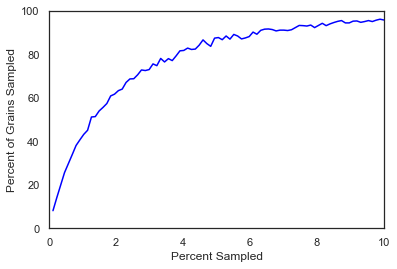

In [304]:
#see how quickly the svm discovers grains
array=raw_data
sizes=np.arange(100,10100,100)
percents=(sizes/len(array))*100

unique_grains=[]
for x in sizes:
    unique_grains.append(grain_areas_test(array,x)/len(np.unique(array[:,5]))*100)

plt.xlim(0,10)
plt.ylim(0,100)

plt.xlabel('Percent Sampled')
plt.ylabel('Percent of Grains Sampled')
sns.lineplot(percents,unique_grains,color='blue')
#next explore cutoff values for confidence sampling

In [278]:
#change initial points option?
grain_areas_test(raw_data_slice,100,'confidence',1)

(nan, nan, nan)

In [143]:
#started at 7:34., end at 10, full p takes at least 2.5 hours, O(n^3) means possibly longer
#2.5k: 4s for p
#5k: 15s
#10k: 89s

# #slice data
# xy_max=18.5 #11.6 for a window of 1,000
# raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]
# print(len(raw_data_slice))

# #define p
# start=time.time()
# p,total_mean,total_var=grain_areas_test(raw_data_slice,len(raw_data_slice),return_p=True)
# end=time.time()
# print(end-start)

In [153]:
#slice data
# xy_max=11.6 #1,000
xy_max=37 #10,000
raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]

#define p
start=time.time()
p,total_mean,total_var=grain_areas_test(raw_data_slice,len(raw_data_slice),return_p=True)
end=time.time()
print(end-start)

#parameters
array=raw_data_slice
#number of points to sample
sizes=np.arange(5,600,100)
percents=(sizes/len(array))*100
fixed_budget=5
# active_sizes=sizes+fixed_budget
# active_sizes=sizes+sizes*(1/5) #sample a fixed 20% of points
# active_percents=(active_sizes/len(array))*100

#four different sampling methods (random, confidence, margin, entropy)
divergences=np.zeros((len(sizes),6))
means=np.zeros((len(sizes),6))
variances=np.zeros((len(sizes),6))

#average results
num_trials=5
while num_trials > 0:
    #divergence for each method    
    rand_div=np.zeros(len(percents))
    conf_div=np.zeros(len(percents))
    marg_div=np.zeros(len(percents))
    entr_div=np.zeros(len(percents))
    #mean for each method    
    rand_mean=np.zeros(len(percents))
    conf_mean=np.zeros(len(percents))
    marg_mean=np.zeros(len(percents))
    entr_mean=np.zeros(len(percents))
    #var for each method    
    rand_var=np.zeros(len(percents))
    conf_var=np.zeros(len(percents))
    marg_var=np.zeros(len(percents))
    entr_var=np.zeros(len(percents))

    #append divergence, mean, and variance
    index=0
    for x in sizes:
        test_budget=fixed_budget
#         test_budget=int(sizes[index]*(1/5)) #budget is a percent
        rand_div[index], rand_mean[index], rand_var[index] = grain_areas_test(array,sizes[index],'random',test_budget)
        conf_div[index], conf_mean[index], conf_var[index] = grain_areas_test(array,sizes[index],'confidence',test_budget)
        marg_div[index], marg_mean[index], marg_var[index] = grain_areas_test(array,sizes[index],'margin',test_budget)
        entr_div[index], entr_mean[index], entr_var[index] = grain_areas_test(array,sizes[index],'entropy',test_budget)
        index+=1

    #add to array
    divergences[:,0]+=rand_div
    divergences[:,1]+=conf_div
    divergences[:,2]+=marg_div
    divergences[:,3]+=entr_div

    means[:,0]+=rand_mean
    means[:,1]+=conf_mean
    means[:,2]+=marg_mean
    means[:,3]+=entr_mean

    variances[:,0]+=rand_div
    variances[:,1]+=conf_var
    variances[:,2]+=marg_var
    variances[:,3]+=entr_var
    num_trials-=1

#prevent division by zero
num_trials=5
#average results        
divergences=divergences/num_trials
means=means/num_trials
variances=variances/num_trials

#slice results
avg_rand_div=divergences[:,0]
avg_conf_div=divergences[:,1]
avg_marg_div=divergences[:,2]
avg_entr_div=divergences[:,3]

avg_rand_mean=means[:,0]
avg_conf_mean=means[:,1]
avg_marg_mean=means[:,2]
avg_entr_mean=means[:,3]

avg_rand_var=variances[:,0]
avg_conf_var=variances[:,1]
avg_marg_var=variances[:,2]
avg_entr_var=variances[:,3]

57.654557943344116


<AxesSubplot:title={'center':'Grain Areas - SVM (Batch Size = 5, Trials = 5)'}, xlabel='Percent', ylabel='JS Divergence'>

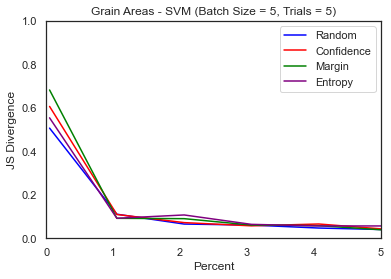

In [157]:
#plot JS results
plt.xlim(0,5)
plt.ylim(0,1)
plt.title('Grain Areas - SVM (Batch Size = 5, Trials = 5)')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')
sns.lineplot(percents,avg_rand_div,color='blue',label='Random')
sns.lineplot(percents,avg_conf_div,color='red',label='Confidence')
sns.lineplot(percents,avg_marg_div,color='green',label='Margin')
sns.lineplot(percents,avg_entr_div,color='purple',label='Entropy')

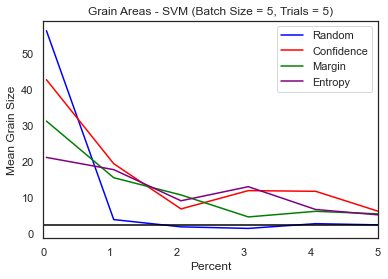

In [158]:
#plot JS results
plt.xlim(0,5)
# plt.ylim(0,0.2)
plt.title('Grain Areas - SVM (Batch Size = 5, Trials = 5)')
plt.xlabel('Percent')
plt.ylabel('Mean Grain Size')
sns.lineplot(percents,avg_rand_mean,color='blue',label='Random')
sns.lineplot(percents,avg_conf_mean,color='red',label='Confidence')
sns.lineplot(percents,avg_marg_mean,color='green',label='Margin')
sns.lineplot(percents,avg_entr_mean,color='purple',label='Entropy')
plt.axhline(y=total_mean, color='black', label='Actual Mean')

In [212]:
#create model
#use a high value of C to heavily penalize misclassified data (keep grains seperate)
#use a high value of gamma to allow curve to fit to individuals points - 'waviness' 
xy_max=37
raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]
print(len(raw_data_slice))

9951


In [209]:
def svm_accuracy(array,size,param_1=1e10,param_2=1):
    #slice data
    X_full=array[:,3:5]
    Y_full=array[:,5]
    X=X_full[np.random.choice(X_full.shape[0], size, replace=False), :]
    Y=Y_full[np.random.choice(Y_full.shape[0], size, replace=False)]
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    #create and fit model
    model = SVC(kernel='rbf', C=param_1, gamma=param_2)
    model.fit(X, Y)

    #return overall accuracy
    Z = model.predict(X_full)
    return accuracy_score(Y_full, Z)

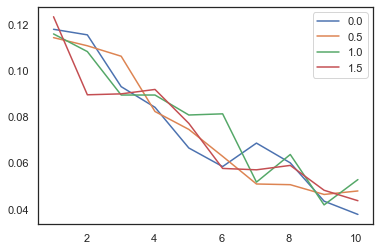

In [213]:
array=raw_data_slice

param_1_range=np.arange(1,1e10,1e9)
param_2_range=np.arange(0,2,0.5)

sizes=np.arange(100,1100,100)
percents=(sizes/len(array))*100

for param in param_2_range:
    
    accuracy=[]
    for size in sizes:
        accuracy.append(svm_accuracy(array,size))
    sns.lineplot(percents,accuracy,label=str(param))

In [ ]:
#slice data
# xy_max=11.6 #1,000
xy_max=37 #10,000
raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]

#define p
start=time.time()
p,total_mean,total_var=grain_areas_test(raw_data_slice,len(raw_data_slice),return_p=True)
end=time.time()
print(end-start)

#parameters
array=raw_data_slice
#number of points to sample
sizes=np.arange(5,600,100)
percents=(sizes/len(array))*100
fixed_budget=5
# active_sizes=sizes+fixed_budget
# active_sizes=sizes+sizes*(1/5) #sample a fixed 20% of points
# active_percents=(active_sizes/len(array))*100

#four different sampling methods (random, confidence, margin, entropy)
divergences=np.zeros((len(sizes),6))
means=np.zeros((len(sizes),6))
variances=np.zeros((len(sizes),6))

#average results
num_trials=5
while num_trials > 0:
    #divergence for each method    
    rand_div=np.zeros(len(percents))
    conf_div=np.zeros(len(percents))
    marg_div=np.zeros(len(percents))
    entr_div=np.zeros(len(percents))
    #mean for each method    
    rand_mean=np.zeros(len(percents))
    conf_mean=np.zeros(len(percents))
    marg_mean=np.zeros(len(percents))
    entr_mean=np.zeros(len(percents))
    #var for each method    
    rand_var=np.zeros(len(percents))
    conf_var=np.zeros(len(percents))
    marg_var=np.zeros(len(percents))
    entr_var=np.zeros(len(percents))

    #append divergence, mean, and variance
    index=0
    for x in sizes:
        test_budget=fixed_budget
#         test_budget=int(sizes[index]*(1/5)) #budget is a percent
        rand_div[index], rand_mean[index], rand_var[index] = grain_areas_test(array,sizes[index],'random',test_budget)
        conf_div[index], conf_mean[index], conf_var[index] = grain_areas_test(array,sizes[index],'confidence',test_budget)
        marg_div[index], marg_mean[index], marg_var[index] = grain_areas_test(array,sizes[index],'margin',test_budget)
        entr_div[index], entr_mean[index], entr_var[index] = grain_areas_test(array,sizes[index],'entropy',test_budget)
        index+=1

    #add to array
    divergences[:,0]+=rand_div
    divergences[:,1]+=conf_div
    divergences[:,2]+=marg_div
    divergences[:,3]+=entr_div

    means[:,0]+=rand_mean
    means[:,1]+=conf_mean
    means[:,2]+=marg_mean
    means[:,3]+=entr_mean

    variances[:,0]+=rand_div
    variances[:,1]+=conf_var
    variances[:,2]+=marg_var
    variances[:,3]+=entr_var
    num_trials-=1

#prevent division by zero
num_trials=5
#average results        
divergences=divergences/num_trials
means=means/num_trials
variances=variances/num_trials

#slice results
avg_rand_div=divergences[:,0]
avg_conf_div=divergences[:,1]
avg_marg_div=divergences[:,2]
avg_entr_div=divergences[:,3]

avg_rand_mean=means[:,0]
avg_conf_mean=means[:,1]
avg_marg_mean=means[:,2]
avg_entr_mean=means[:,3]

avg_rand_var=variances[:,0]
avg_conf_var=variances[:,1]
avg_marg_var=variances[:,2]
avg_entr_var=variances[:,3]

In [179]:
# X=raw_data_slice[:,3:5]
# Y=raw_data_slice[:,5]

# x_min, x_max = X[:, 0].min(), X[:, 0].max()
# y_min, y_max = X[:, 1].min(), X[:, 1].max()

# model = SVC(kernel='rbf', C=1e10, gamma=1)
# model.fit(X, Y)

# # plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='prism')
# actual=np.stack((X[:,0],X[:,1],Y), axis=-1)

# # create grid to evaluate model
# num_samples=200 #increase by a factor of ten, old was 200 for a 12x12 window
# x = np.linspace(x_min, x_max, num_samples)
# y = np.linspace(y_min, y_max, num_samples)
# xx, yy = np.meshgrid(x, y)
# Z = model.predict(np.c_[xx.ravel(), yy.ravel()])


# # plt.scatter(xx.ravel(), yy.ravel(), c=Z, s=10, cmap='prism')
# predicted=np.stack((xx.ravel(),yy.ravel(),Z), axis=-1)
# Z = Z.reshape(xx.shape)
# plt.scatter(xx.ravel(),yy.ravel(),c=Z,cmap='prism')
# # plt.xlim(x_min,x_max)
# # plt.ylim(y_min,y_max)
# # print(len(np.unique(Z)))
# # fig = plt.figure()
# # ax = plt.axes(projection='3d')
# # ax.scatter3D(xx, yy, Z);
# # print(model.predict([[10,1]]))

# # boundary=plt.contour(xx, yy, Z, alpha=.5)
# # plt.close()
# # p = boundary.collections[1].get_paths()[0]
# # v = p.vertices
# # coords = v[:,[0,1]]

# # plt.scatter(coords[:,0],coords[:,1])
# # plt.scatter(X[:, 0], X[:, 1], c=Y, s=10, cmap='prism')

In [42]:
# array=raw_data_slice

# #slice data
# indexes=np.random.choice(array.shape[0], sample, replace=False)
# random_raw_data=array[indexes, :]
# unlabeled_raw_data=np.delete(array,indexes,axis=0)
# coords=unlabeled_raw_data[:,3:5]

# #create boundaries
# X=array[:,3:5]
# Y=array[:,5]
# #needs more than one grain and four points
# if (len(np.unique(Y)) < 2) or (len(X) < 4):
#     return np.nan, np.nan, np.nan

# x_min, x_max = X[:, 0].min(), X[:, 0].max()
# y_min, y_max = X[:, 1].min(), X[:, 1].max()

# model = SVC(kernel='rbf', C=1e10, gamma=1,probability=True)
# model.fit(X, Y)

# if strategy != 'random'::
#     #https://davefernig.com/2018/02/23/active-learning/#more-1186
#     probs = model.predict_proba(coords)

#     if strategy=='confidence':
#         # Rank predictions by confidence:
#         scores = 1 - np.amax(probs, axis=1)
#         # Sort them:
#         rankings = np.argsort(-scores)

#     if strategy=='margin':
#         # Compute the margin of each instance:
#         ordered = np.partition(-probs, 1, axis=1)
#         margins = -np.abs(ordered[:,0] - ordered[:, 1])
#         # Sort them:
#         rankings = np.argsort(-margins)

#     if strategy=='entropy':
#         scores = np.apply_along_axis(entropy, 1, probs)
#         rankings = np.argsort(-scores)

#     # Take the points for which we have a budget:
#     active_sample = unlabeled_raw_data[rankings[:budget]]
    
#     #append data and retrain
#     X=np.vstack((X,active_sample[:,3:5]))
#     Y=np.vstack((Y,active_sample[:,5]))

#     x_min, x_max = X[:, 0].min(), X[:, 0].max()
#     y_min, y_max = X[:, 1].min(), X[:, 1].max()

#     model = SVC(kernel='rbf', C=1e10, gamma=1,probability=False) #probability is slow, no need
#     model.fit(X, Y)

In [8]:
# #create model
# #use a high value of C to heavily penalize misclassified data (keep grains seperate)
# #use a high value of gamma to allow curve to fit to individuals points - 'waviness' 
# raw_data_slice=raw_data[np.where((raw_data[:,5]==2) | (raw_data[:,5]==3))]
# X=raw_data_slice[:,3:5]
# Y=raw_data_slice[:,5]

# # random_raw_data=sliced_raw_data[np.random.choice(sliced_raw_data.shape[0], 10, replace=False), :]
# # X=random_raw_data[:,3:5]
# # Y=random_raw_data[:,5]

# #create model
# model = SVC(kernel='rbf', C=1e10, gamma=1)
# model.fit(X, Y)

# #plot model
# plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
# plot_svc_decision_function(model);

# xy_max=12
# # raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]

# raw_data_slice=raw_data[np.where((raw_data[:,5]==2) | (raw_data[:,5]==3))]

# X=raw_data_slice[:,3:5]
# Y=raw_data_slice[:,5]

# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# model = SVC(kernel='rbf', C=1e10, gamma=0.1)
# model.fit(X, Y)

# # create grid to evaluate model
# num_samples=200
# x = np.linspace(x_min, x_max, num_samples)
# y = np.linspace(y_min, y_max, num_samples)
# xx, yy = np.meshgrid(x, y)
# Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# plt.xlim(x_min,x_max)
# plt.ylim(y_min,y_max)
# boundary=plt.contourf(xx, yy, Z, alpha=.5)
# # plt.close()
# p = boundary.collections[0].get_paths()[0]
# v = p.vertices
# coords = v[:,[0,1]]

# plt.scatter(coords[:,0],coords[:,1])
# plt.scatter(X[:, 0], X[:, 1], c=Y, s=10, cmap='prism')

In [110]:
# xy_max=12
# raw_data_slice=raw_data[np.where((raw_data[:,3]<=xy_max) & (raw_data[:,4]<=xy_max))]
# # raw_data_slice=raw_data_slice[np.random.choice(raw_data_slice.shape[0], 500, replace=False), :]
# X=raw_data_slice[:,3:5]
# Y=raw_data_slice[:,5]

# x_min, x_max = X[:, 0].min(), X[:, 0].max()
# y_min, y_max = X[:, 1].min(), X[:, 1].max()

# model = SVC(kernel='rbf', C=1e10, gamma=1)
# model.fit(X, Y)

# # plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='prism')
# actual=np.stack((X[:,0],X[:,1],Y), axis=-1)

# # create grid to evaluate model
# num_samples=2000 #increase by a factor of ten, old was 200 for a 12x12 window
# x = np.linspace(x_min, x_max, num_samples)
# y = np.linspace(y_min, y_max, num_samples)
# xx, yy = np.meshgrid(x, y)
# Z = model.predict(np.c_[xx.ravel(), yy.ravel()])


# # plt.scatter(xx.ravel(), yy.ravel(), c=Z, s=10, cmap='prism')
# predicted=np.stack((xx.ravel(),yy.ravel(),Z), axis=-1)
# Z = Z.reshape(xx.shape)

# # plt.xlim(x_min,x_max)
# # plt.ylim(y_min,y_max)
# # print(len(np.unique(Z)))
# # fig = plt.figure()
# # ax = plt.axes(projection='3d')
# # ax.scatter3D(xx, yy, Z);
# # print(model.predict([[10,1]]))

# # boundary=plt.contour(xx, yy, Z, alpha=.5)
# # # plt.close()
# # p = boundary.collections[1].get_paths()[0]
# # v = p.vertices
# # coords = v[:,[0,1]]

# # # plt.scatter(coords[:,0],coords[:,1])
# # plt.scatter(X[:, 0], X[:, 1], c=Y, s=10, cmap='prism')

# # # actual_slice=actual[np.where(actual[:,2]==4)]
# # predicted_slice=predicted[np.where(predicted[:,2]==4)]

# # # plt.scatter(actual_slice[:, 0], actual_slice[:, 1], c=actual_slice[:,2], s=50, cmap='prism')

# # plt.scatter(predicted_slice[:, 0], predicted_slice[:, 1], c=predicted_slice[:,2], s=50, cmap='prism')

# # plt.scatter(predicted[:, 0], predicted[:, 1], c=predicted[:,2], s=50, cmap='prism')

# # array=predicted
# # #array to hold boundaries and adj grain
# # bounds_grains=np.zeros((len(array),2))
# # svm=np.concatenate((array,bounds_grains),axis=1)

# # #create ajd dict
# # point_adj=adj_dict(array)
# # # create grain adj dict
# # grain_adj=defaultdict(set)
# # #create list of boundary disorientations
# # for key in point_adj:
# #     grain_ID_1=predicted[key][2]
# #     for value in point_adj[key]:
# #         grain_ID_2=predicted[value][2]
# #         if grain_ID_1 != grain_ID_2:
# #             svm[key,3]=1
# #             svm[value,3]=1
# #             #create grain adj dict
# #             grain_ID_1=int(grain_ID_1)
# #             grain_ID_2=int(grain_ID_2)
# #             svm[key,4]=grain_ID_2
# #             svm[value,4]=grain_ID_1
# #             grain_adj[int(grain_ID_1)].add(grain_ID_2)
# #             grain_adj[int(grain_ID_2)].add(grain_ID_1)

# # svm_slice=svm[np.where(svm[:,3]==1)]

In [7]:
# plt.xlim(0,12)
# plt.ylim(0,12)
# svm_slice=svm[np.where((svm[:,2]==99) & (svm[:,3]==1) & (svm[:,4]==42))]
# sns.scatterplot(x=svm_slice[:,0],y=svm_slice[:,1],marker='+')

# #length of boundary
# svm_slice=svm[np.where((svm[:,2]==99) & (svm[:,3]==1) & (svm[:,4]==42))]
# x = np.ravel(svm_slice_1[:,0])
# y = np.ravel(svm_slice_1[:,1])
# dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2
# print(np.sum(np.sqrt(dist_array)))

# array=raw_data_slice
# grain_slice_1=array[np.where(array[:,5]==99)]
# grain_slice_2=array[np.where(array[:,5]==42)]

# #add row IDs
# grain_slice_1=np.concatenate((grain_slice_1,np.arange(0,len(grain_slice_1)).reshape(-1,1)),axis=1)
# grain_slice_2=np.concatenate((grain_slice_2,np.arange(0,len(grain_slice_2)).reshape(-1,1)),axis=1)

# #create two new columns to hold nearest neighbor and a third column for misorientation
# svm_coords=svm_slice[:,[0,1]]
# neighbors_misorients=np.zeros((len(svm_coords),3))
# coords_misorient=np.concatenate((svm_coords,neighbors_misorients),axis=1)

# #row ID of nearest coord in grain 1
# row_1_ID=0
# #for each SVM boundary point
# for row_1 in coords_misorient:
#     coords_1=row_1[0:2]
#     distances_and_row_IDs=defaultdict(set)
#     #for each point in the first grain
#     for row_2 in grain_slice_1:
#         coords_2=row_2[3:5]
#         #calculate distance
#         dist=round(distance.euclidean(coords_1,coords_2),3)
#         #add row ID of grain boundary point for misorient
#         distances_and_row_IDs[dist].add(row_2[6])
#     #find minimum distance
#     min_dist = min(distances_and_row_IDs.keys())
#     #add row ID of min dist
#     bound_1_ID=list(distances_and_row_IDs[min_dist])
#     coords_misorient[row_1_ID,2]=bound_1_ID[0]
#     row_1_ID+=1       

# #row ID of nearest coord in grain 2
# row_1_ID=0
# #for each SVM boundary point
# for row_1 in coords_misorient:
#     coords_1=row_1[0:2]
#     distances_and_row_IDs=defaultdict(set)
#     #for each point in the first grain boundary
#     for row_2 in grain_slice_2:
#         coords_2=row_2[3:5]
#         #calculate distance
#         dist=round(distance.euclidean(coords_1,coords_2),3)
#         #add row ID of grain boundary point for misorient
#         distances_and_row_IDs[dist].add(row_2[6])
#     #find minimum distance
#     min_dist = min(distances_and_row_IDs.keys())
#     #add row ID of min dist
#     bound_1_ID=list(distances_and_row_IDs[min_dist])
#     coords_misorient[row_1_ID,3]=bound_1_ID[0]
#     row_1_ID+=1 

# #calculate each misorientation
# row_ID=0
# for row in coords_misorient:
#     key=int(coords_misorient[row_ID,2])
#     euler_one=[grain_slice_1[key][0],grain_slice_1[key][1],grain_slice_1[key][2]]
#     value=int(coords_misorient[row_ID,3])
#     euler_two=[grain_slice_2[value][0],grain_slice_2[value][1],grain_slice_2[value][2]]
#     coords_misorient[row_ID,4]=disorientation(euler_one,euler_two)
#     row_ID+=1

# #find the total average and append
# print(np.mean(coords_misorient[:,4]))
# # avg_boundary_disorients[index]=np.mean(coords_misorient[:,4])

In [92]:
# #could remove duplicates and randomly sample remainder to produce curve that aligns with random
# def jitter_2(res,array,randomness=0,binsize=249,hist=True,mean_var=False):
#     #array of points to randomly sample after removing duplicates
#     sampled=np.zeros((len(array),1))
#     array=np.concatenate((array,sampled.reshape(-1,1)),axis=1)
    
#     #row_IDs to access unsampled points
#     row_IDs=np.arange(0,len(array))
#     array=np.concatenate((array,row_IDs.reshape(-1,1)),axis=1)
    
#     #total number of points to randomly sample
#     grid_row_IDs=row_IDs[::res]
#     grid_row_IDs=grid_row_IDs.reshape(-1,1)
    
#     #introduce randomness
#     minimum=np.zeros((len(grid_row_IDs),1))
#     minimum=minimum-randomness
#     maximum=np.ones((len(grid_row_IDs),1))
#     maximum=maximum+randomness
#     min_max=np.concatenate((minimum.reshape(-1,1),maximum.reshape(-1,1)),axis=1)
    
#     #ensure the range of values in within the array
    
#     #add/subtract randomness
#     randomness_array=np.zeros((len(grid_row_IDs),1))
#     for row in np.arange(len(grid_row_IDs)):
#         randomness_array[row]=np.random.randint(int(min_max[row,0]),int(min_max[row,1]))
    
#     #add array to create jitter
#     jitter_array=grid_row_IDs+randomness_array
    
#     #remove points outside of range (0,len)...
#     in_range=np.where((jitter_array[:,0] >= 0) & (jitter_array[:,0] < len(array)))
# #     print(len(in_range[0]))
# #     out_of_range=np.where((jitter_array[:,0] < 0) | (jitter_array[:,0] >= len(array)))
# #     print(len(out_of_range[0]))
#     jitter_array=jitter_array[in_range]
    
#     #...and add back in by random sampling
#     random_array=array[np.random.choice(array.shape[0], (len(grid_row_IDs)-len(in_range[0])), replace=True), 7]
#     random_array=random_array.reshape(-1,1)
#     jitter_array=np.append(jitter_array,random_array)
#     jitter_array=jitter_array.reshape(-1,1)
    
#     #jitter sample data
#     jitter_coords_and_grain_IDs=array[jitter_array.astype(int).flatten(),:]
#     jitter_coords=jitter_coords_and_grain_IDs[:,0:2]
#     jitter_grain_IDs=jitter_coords_and_grain_IDs[:,2]
    
# #     #get areas
# #     vol=voronoi_volumes(jitter_coords)   
# #     #turn area into percent of total area
# #     norm_vol=(vol)/sum(vol)
# #     #multiply by total number of pixels to find how many pixels in each area
# #     scale_vol=norm_vol*87017
# #     #round to nearest whole number
# #     round_vol=np.round(scale_vol,decimals=0)
# #     #create array, col1 is ID, col2 is area
# #     grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)
# #     #get unique IDs and their count
# #     unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
# #     #create array to hold unique IDs and their sizes added together
# #     unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
# #     #construct IDs and count
# #     for row in unique_grain_IDs_and_total_areas:
# #         grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
# #         total=np.sum(grain[:,1])
# #         row[1]=total
    
# #     #double edge grains
# #     row_ID=0
# #     for row in unique_grain_IDs_and_total_areas:
# #         #if the grain ID is an edge
# #         if np.isin(row[0],edge_grains[:,0]):
# #             #double the total grain area
# #             unique_grain_IDs_and_total_areas[row_ID,1]*=2
# #         row_ID+=1
        
# #     #return count for hist
# #     count = unique_grain_IDs_and_total_areas[:,1]
     
# #     q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
# #     q_hist = np.append(q_hist, 0)
# #     q=q_hist
# #     q[q==0]=[0.0000000000001]
# #     if hist==True:
# #         return q
    
# #     if mean_var==True:
# #         mean=np.mean(count)
# #         var=np.var(count)
# #         return mean, var

# # # jitter_2(1,raw_data)
# # jitter_2(2,raw_data,randomness=100)

# def jitter(array,num_boxes,percent,binsize=249,hist=True,mean_var=False): 
    
#     #array to hold (un)sampled points
#     sampled=np.zeros((len(raw_data),1))
#     array=np.concatenate((array,sampled.reshape(-1,1)),axis=1)
    
#     #row_IDs to access unsampled points
#     row_IDs=np.arange(0,len(raw_data))
#     array=np.concatenate((array,row_IDs.reshape(-1,1)),axis=1)
    
#     #total number of points to randomly sample
#     num_points=len(array)*(percent/100)
    
#     #number of points to randomly sample in each box
#     num_box_points=int(num_points/num_boxes)
    
#     #a=l^2 (i.e. 22, 4x4 etc)
#     square_dim=np.sqrt(num_boxes)
    
#     #side length of the square
#     x_total_side_len=float(max(raw_data[:,3]))
#     y_total_side_len=float(max(raw_data[:,4]))
    
#     #side length of each jitter square
#     x_side_len=x_total_side_len/square_dim
#     y_side_len=y_total_side_len/square_dim
    
#     #number of sides to iterate for loop
#     num_sides=int(round(x_total_side_len/x_side_len))
    
#     #create array to hold the result
#     jittered_array=np.zeros(array.shape[1])
    
#     num_points_lost=0
    
#     #break down into gridded sample 
#     lower_x_bound=0
#     lower_y_bound=0
    
#     new_x_side_len=x_side_len
#     for x in range(0,num_sides,1): 
#         x_slice=array[np.where((lower_x_bound<=array[:,3]) & (array[:,3]<new_x_side_len))]
# #         print(str(lower_x_bound)+', '+str(new_x_side_len))
#         lower_x_bound+=x_side_len
#         new_x_side_len+=x_side_len
        
# #         print(len(x_slice))
        
#         lower_y_bound=0
#         new_y_side_len=y_side_len
#         for y in range(0,num_sides,1):
#             y_slice=array[np.where((lower_y_bound<=x_slice[:,4]) & (x_slice[:,4]<new_y_side_len))]
# #             print(str(lower_y_bound)+', '+str(new_y_side_len))
#             lower_y_bound+=y_side_len
#             new_y_side_len+=y_side_len
        
# #             print(len(y_slice))
            
#             #randomly sample points in box, box might have less than avg number of points, throwing an exception
#             try:
#                 random_boxed_points=y_slice[np.random.choice(y_slice.shape[0], num_box_points, replace=False), :]
#             #if exception, just use all of the points
#             except:
#                 random_boxed_points=y_slice
#                 num_points_lost+=num_box_points-len(y_slice)

#             array[[y_slice[:,7].astype(int)],6]=1
#             jittered_array=np.vstack((jittered_array,random_boxed_points))
            
#     #delete the placeholder first row of the answer     
#     jittered_array=np.delete(jittered_array, 0, 0)
    
#     #randomly sample the unsampled points (due to rounding errors, irregularities, etc)
#     unsampled=array[np.where(array[:,6]!=1)]
#     unsampled=unsampled[np.random.choice(unsampled.shape[0], num_points_lost, replace=False), :]
#     jittered_array=np.vstack((jittered_array,unsampled))
    
#     print(len(unsampled))
#     print(len(jittered_array))








    
# #     #turn into prob vec
# #     jitter_coords=jittered_array[:,[3,4]]
# #     jitter_grain_IDs=jittered_array[:,5]






    
# #     #get areas
# #     vol=voronoi_volumes(jitter_coords)   
# #     #turn area into percent of total area
# #     norm_vol=(vol)/sum(vol)
# #     #multiply by total number of pixels to find how many pixels in each area
# #     scale_vol=norm_vol*87017
# #     #round to nearest whole number
# #     round_vol=np.round(scale_vol,decimals=0)
# #     #create array, col1 is ID, col2 is area
# #     grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)
# #     #get unique IDs and their count
# #     unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
# #     #create array to hold unique IDs and their sizes added together
# #     unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
# #     #construct IDs and count
# #     for row in unique_grain_IDs_and_total_areas:
# #         grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
# #         total=np.sum(grain[:,1])
# #         row[1]=total
    
# #     #double edge grains
# #     row_ID=0
# #     for row in unique_grain_IDs_and_total_areas:
# #         #if the grain ID is an edge
# #         if np.isin(row[0],edge_grains[:,0]):
# #             #double the total grain area
# #             unique_grain_IDs_and_total_areas[row_ID,1]*=2
# #         row_ID+=1
        
# #     #return count for hist
# #     count = unique_grain_IDs_and_total_areas[:,1]
     
# #     q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
# #     q_hist = np.append(q_hist, 0)
# #     q=q_hist
# #     q[q==0]=[0.0000000000001]
# #     if hist==True:
# #         return q
    
# #     if mean_var==True:
# #         mean=np.mean(count)
# #         var=np.var(count)
# #         return mean, var

# # instead use grid and the increase randomness of step size

# # jitter(raw_data,1,100,hist=True)

# # jitter(raw_data,4,100,hist=True)

# # jitter(raw_data,16,100,hist=True)

# # jitter(raw_data,484,100,hist=True)

# # jitter(raw_data,86436,100,hist=True)

# #is poor grid sampling due to raster nature?